In [1]:
!nvidia-smi

Thu Nov 13 15:09:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
|  0%   33C    P8             18W /  500W |      36MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Cell 2
import os
import time
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler

import torchvision
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# Reproducibility
# ------------------------------------------------------------------
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# ------------------------------------------------------------------
# Device & mixed-precision
# ------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_amp = device.type == 'cuda'
scaler = GradScaler(enabled=use_amp)

print(f"Device: {device} | AMP: {use_amp}")

Device: cuda | AMP: True


In [3]:
# Cell 3
DATA_ROOT = Path("./data")
DATA_ROOT.mkdir(exist_ok=True)

# CIFAR-10 mean / std (official)
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD  = (0.2470, 0.2435, 0.2616)

train_tfms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    T.Normalize(CIFAR_MEAN, CIFAR_STD),
])

test_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR_MEAN, CIFAR_STD),
])

full_train = CIFAR10(root=DATA_ROOT, train=True,  download=True, transform=train_tfms)
test_set   = CIFAR10(root=DATA_ROOT, train=False, download=True, transform=test_tfms)

# 90 % train  /  10 % val
val_size   = 5_000
train_set, val_set = random_split(
    full_train,
    [len(full_train) - val_size, val_size],
    generator=torch.Generator().manual_seed(42),
)

# Validation uses test-time transforms
val_set.dataset.transform = test_tfms

print(f"Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")

Files already downloaded and verified
Files already downloaded and verified
Train: 45000 | Val: 5000 | Test: 10000


In [4]:
# Cell 4
BATCH_SIZE = 128
NUM_WORKERS = min(4, os.cpu_count())

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

In [25]:
# Cell 5 – keep exactly the code you already have for:
#   AdaptiveShapeConv, GeometricPrior, SEBlock,
#   MicroBlock, MicroSignBackbone, ClassificationHead, MicroSignClassifier
# (copy-paste the whole block from your original notebook)
# ------------------------------------------------------------------

class ChannelShuffle(nn.Module):
    """Efficient channel shuffle for group convolutions"""
    def __init__(self, groups):
        super().__init__()
        self.groups = groups
    
    def forward(self, x):
        b, c, h, w = x.size()
        channels_per_group = c // self.groups
        x = x.view(b, self.groups, channels_per_group, h, w)
        x = x.transpose(1, 2).contiguous()
        x = x.view(b, c, h, w)
        return x


class DynamicConv(nn.Module):
    """
    Dynamic convolution with multiple kernels and attention-based weighting.
    Learns which kernel pattern works best for current input.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, num_kernels=4):
        super().__init__()
        self.num_kernels = num_kernels
        padding = kernel_size // 2
        
        # Multiple parallel kernels
        self.kernels = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, 
                     bias=False, groups=1)
            for _ in range(num_kernels)
        ])
        
        # Attention to select kernels
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, num_kernels, 1),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        # Get attention weights for each kernel
        attn = self.attention(x)  # [B, num_kernels, 1, 1]
        
        # Apply all kernels
        outputs = [kernel(x) for kernel in self.kernels]
        
        # Weighted sum
        out = sum(attn[:, i:i+1] * outputs[i] for i in range(self.num_kernels))
        return out


class SEBlock(nn.Module):
    """Squeeze-and-Excitation block"""
    def __init__(self, channels, reduction=4):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Conv2d(channels, max(channels // reduction, 8), 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(max(channels // reduction, 8), channels, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y = self.squeeze(x)
        y = self.excitation(y)
        return x * y


class EfficientBlock(nn.Module):
    """
    Efficient inverted residual block with improvements:
    - Dynamic convolution for better feature learning
    - Channel shuffle for cross-group communication
    - Proper normalization and activation placement
    """
    def __init__(self, in_channels, out_channels, stride=1, expansion=4, 
                 use_dynamic=False, use_se=True):
        super().__init__()
        self.stride = stride
        self.use_residual = (stride == 1 and in_channels == out_channels)
        hidden_dim = in_channels * expansion
        
        # Expansion phase
        if expansion != 1:
            self.expand = nn.Sequential(
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True)
            )
        else:
            self.expand = None
        
        # Depthwise convolution
        dw_channels = hidden_dim if expansion != 1 else in_channels
        if use_dynamic and stride == 1:
            self.depthwise = nn.Sequential(
                DynamicConv(dw_channels, dw_channels, kernel_size=3, stride=stride, num_kernels=3),
                nn.BatchNorm2d(dw_channels),
                nn.ReLU6(inplace=True)
            )
        else:
            self.depthwise = nn.Sequential(
                nn.Conv2d(dw_channels, dw_channels, 3, stride, 1, 
                         groups=dw_channels, bias=False),
                nn.BatchNorm2d(dw_channels),
                nn.ReLU6(inplace=True)
            )
        
        # SE block
        self.se = SEBlock(dw_channels) if use_se else None
        
        # Projection
        self.project = nn.Sequential(
            nn.Conv2d(dw_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        # Channel shuffle for grouped convs
        if in_channels >= 16 and out_channels >= 16:
            self.shuffle = ChannelShuffle(groups=4)
        else:
            self.shuffle = None
    
    def forward(self, x):
        identity = x
        
        # Expansion
        if self.expand is not None:
            out = self.expand(x)
        else:
            out = x
        
        # Depthwise
        out = self.depthwise(out)
        
        # SE attention
        if self.se is not None:
            out = self.se(out)
        
        # Projection
        out = self.project(out)
        
        # Residual connection
        if self.use_residual:
            out = out + identity
        
        # Channel shuffle
        if self.shuffle is not None:
            out = self.shuffle(out)
        
        return out


class SpatialAttention(nn.Module):
    """Lightweight spatial attention for important regions"""
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return x * self.sigmoid(out)


class MicroNet(nn.Module):
    """
    MicroNet: Efficient backbone optimized for microcontrollers and small images
    
    Key features:
    - Dynamic convolutions for adaptive feature learning
    - Proper channel progression for small images
    - Efficient attention mechanisms
    - Support for both large (224x224) and small (32x32) images
    """
    
    CONFIGS = {
        'nano': {
            'width_mult': 0.25,
            'depths': [1, 2, 2, 1],
            'expansions': [1, 4, 4, 4],
            'description': 'Extreme edge (20-50KB)',
            'use_dynamic': [False, False, False, False],
            'use_se': [False, True, True, False]
        },
        'micro': {
            'width_mult': 0.5,
            'depths': [2, 2, 3, 2],
            'expansions': [1, 4, 6, 6],
            'description': 'Ultra-lightweight (100-200KB)',
            'use_dynamic': [False, True, True, False],
            'use_se': [True, True, True, True]
        },
        'tiny': {
            'width_mult': 0.75,
            'depths': [2, 3, 4, 2],
            'expansions': [1, 4, 6, 6],
            'description': 'Lightweight (200-400KB)',
            'use_dynamic': [False, True, True, True],
            'use_se': [True, True, True, True]
        },
        'small': {
            'width_mult': 1.0,
            'depths': [2, 3, 5, 3],
            'expansions': [1, 4, 6, 6],
            'description': 'Balanced (400-800KB)',
            'use_dynamic': [True, True, True, True],
            'use_se': [True, True, True, True]
        },
        'base': {
            'width_mult': 1.25,
            'depths': [3, 4, 6, 3],
            'expansions': [1, 4, 6, 6],
            'description': 'High accuracy (800KB-1.5MB)',
            'use_dynamic': [True, True, True, True],
            'use_se': [True, True, True, True]
        }
    }
    
    def __init__(self, variant='micro', num_classes=None, return_stages=None,
                 dropout=0.2, frozen_stages=-1, input_size=224):
        """
        Args:
            variant: Model size variant
            num_classes: If provided, adds classification head
            return_stages: Which stages to return [1,2,3,4]
            dropout: Dropout rate
            frozen_stages: Freeze stages for transfer learning
            input_size: Input image size (224 for ImageNet, 32 for CIFAR)
        """
        super().__init__()
        
        if variant not in self.CONFIGS:
            raise ValueError(f"Variant must be one of {list(self.CONFIGS.keys())}")
        
        config = self.CONFIGS[variant]
        width_mult = config['width_mult']
        depths = config['depths']
        expansions = config['expansions']
        use_dynamic = config['use_dynamic']
        use_se = config['use_se']
        
        def make_divisible(v, divisor=8):
            return max(divisor, int(v + divisor / 2) // divisor * divisor)
        
        # Adjust channels based on input size
        base_channels = [16, 24, 32, 64, 128] if input_size <= 64 else [24, 32, 64, 128, 256]
        
        self.out_channels = [make_divisible(c * width_mult) for c in base_channels]
        
        # Stem - different for small vs large images
        if input_size <= 64:
            # For CIFAR-10 (32x32) - gentler downsampling
            self.stem = nn.Sequential(
                nn.Conv2d(3, self.out_channels[0], 3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(self.out_channels[0]),
                nn.ReLU6(inplace=True)
            )
        else:
            # For ImageNet (224x224) - standard downsampling
            self.stem = nn.Sequential(
                nn.Conv2d(3, self.out_channels[0], 3, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(self.out_channels[0]),
                nn.ReLU6(inplace=True)
            )
        
        # Build stages
        self.stages = nn.ModuleList()
        in_channels = self.out_channels[0]
        
        for stage_idx in range(len(depths)):
            out_ch = self.out_channels[min(stage_idx + 1, len(self.out_channels) - 1)]
            expansion = expansions[stage_idx]
            
            stage = []
            for block_idx in range(depths[stage_idx]):
                # Adjust stride for small images
                if input_size <= 64:
                    # For CIFAR: only downsample at stage 1 and 2
                    stride = 2 if block_idx == 0 and stage_idx in [1, 2] else 1
                else:
                    # For ImageNet: downsample at all stages
                    stride = 2 if block_idx == 0 else 1
                
                stage.append(EfficientBlock(
                    in_channels if block_idx == 0 else out_ch,
                    out_ch,
                    stride=stride,
                    expansion=expansion,
                    use_dynamic=use_dynamic[stage_idx],
                    use_se=use_se[stage_idx]
                ))
            
            # Add spatial attention at key stages
            if stage_idx in [1, 2]:
                stage.append(SpatialAttention())
            
            self.stages.append(nn.Sequential(*stage))
            in_channels = out_ch
        
        # Store config
        self.variant = variant
        self.config = config
        self.num_classes = num_classes
        self.return_stages = return_stages
        self.frozen_stages = frozen_stages
        self.input_size = input_size
        
        # Classification head
        if num_classes is not None:
            self.global_pool = nn.AdaptiveAvgPool2d(1)
            self.dropout = nn.Dropout(dropout)
            # Add an extra FC layer for better feature learning
            final_channels = self.out_channels[-1]
            self.pre_classifier = nn.Sequential(
                nn.Linear(final_channels, final_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout * 0.5)
            )
            self.classifier = nn.Linear(final_channels, num_classes)
        else:
            self.global_pool = None
            self.classifier = None
        
        self._initialize_weights()
        self._freeze_stages()
        
        self.total_params = sum(p.numel() for p in self.parameters())
        self.trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def _freeze_stages(self):
        if self.frozen_stages >= 0:
            self.stem.eval()
            for param in self.stem.parameters():
                param.requires_grad = False
        
        for i in range(self.frozen_stages):
            if i < len(self.stages):
                self.stages[i].eval()
                for param in self.stages[i].parameters():
                    param.requires_grad = False
    
    def forward_features(self, x):
        outputs = {}
        
        x = self.stem(x)
        if self.return_stages is not None and 0 in self.return_stages:
            outputs['C1'] = x
        
        for idx, stage in enumerate(self.stages):
            x = stage(x)
            if self.return_stages is not None and idx + 1 in self.return_stages:
                outputs[f'C{idx + 2}'] = x
        
        if self.return_stages is None:
            return x
        elif len(outputs) == 1:
            return list(outputs.values())[0]
        else:
            return outputs
    
    def forward(self, x):
        if self.classifier is not None:
            x = self.forward_features(x)
            x = self.global_pool(x)
            x = x.flatten(1)
            x = self.pre_classifier(x)
            x = self.classifier(x)
            return x
        else:
            return self.forward_features(x)
    
    def get_model_info(self):
        return {
            'variant': self.variant,
            'description': self.config['description'],
            'width_multiplier': self.config['width_mult'],
            'depths': self.config['depths'],
            'expansions': self.config['expansions'],
            'output_channels': self.out_channels,
            'return_stages': self.return_stages,
            'num_classes': self.num_classes,
            'input_size': self.input_size,
            'total_parameters': self.total_params,
            'trainable_parameters': self.trainable_params,
            'model_size_mb': self.total_params * 4 / (1024 * 1024),
            'frozen_stages': self.frozen_stages
        }
    
    def train(self, mode=True):
        super().train(mode)
        self._freeze_stages()
        return self


# Detection head
class DetectionHead(nn.Module):
    def __init__(self, in_channels, num_anchors=3, num_classes=80):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, padding=1, 
                     groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels, num_anchors * (5 + num_classes), 1)
        )
    
    def forward(self, x):
        return self.conv(x)


class MicroNetDetector(nn.Module):
    def __init__(self, num_classes=80, variant='micro', input_size=224):
        super().__init__()
        self.backbone = MicroNet(variant=variant, return_stages=[2, 3, 4], 
                                 input_size=input_size)
        
        channels = self.backbone.out_channels
        self.det_heads = nn.ModuleDict({
            'small': DetectionHead(channels[2], num_classes=num_classes),
            'medium': DetectionHead(channels[3], num_classes=num_classes),
            'large': DetectionHead(channels[4], num_classes=num_classes),
        })
    
    def forward(self, x):
        features = self.backbone(x)
        return {
            'small': self.det_heads['small'](features['C3']),
            'medium': self.det_heads['medium'](features['C4']),
            'large': self.det_heads['large'](features['C5']),
        }


# Training utilities
def create_model(task='classification', num_classes=10, variant='micro', 
                input_size=224, pretrained_path=None):
    """
    Unified model creation function
    
    Args:
        task: 'classification', 'detection', or 'backbone'
        num_classes: Number of classes
        variant: Model size
        input_size: Input image size (32 for CIFAR, 224 for ImageNet)
        pretrained_path: Path to pretrained weights
    """
    if task == 'classification':
        model = MicroNet(variant=variant, num_classes=num_classes, 
                        input_size=input_size)
    elif task == 'detection':
        model = MicroNetDetector(num_classes=num_classes, variant=variant,
                                input_size=input_size)
    elif task == 'backbone':
        model = MicroNet(variant=variant, return_stages=[2, 3, 4],
                        input_size=input_size)
    else:
        raise ValueError(f"Unknown task: {task}")
    
    if pretrained_path:
        checkpoint = torch.load(pretrained_path, map_location='cpu')
        state_dict = checkpoint.get('model_state_dict', checkpoint)
        # Remove classifier if loading backbone
        if task in ['detection', 'backbone']:
            state_dict = {k: v for k, v in state_dict.items() 
                         if 'classifier' not in k}
        model.load_state_dict(state_dict, strict=False)
    
    return model


if __name__ == '__main__':
    print("="*80)
    print("MicroNet: Efficient Backbone for Microcontrollers")
    print("="*80)
    
    # Test CIFAR-10 configuration
    print("\n" + "="*80)
    print("CIFAR-10 Configuration (32x32 images)")
    print("="*80)
    
    for variant in ['nano', 'micro', 'tiny']:
        print(f"\n{'-'*80}")
        print(f"Variant: {variant.upper()}")
        print(f"{'-'*80}")
        
        model = create_model('classification', num_classes=10, variant=variant, 
                           input_size=32)
        info = model.get_model_info()
        
        print(f"Description: {info['description']}")
        print(f"Parameters: {info['total_parameters']:,}")
        print(f"Model Size: {info['model_size_mb']:.2f} MB")
        print(f"Depths: {info['depths']}")
        print(f"Expansions: {info['expansions']}")
        
        x = torch.randn(4, 3, 32, 32)
        with torch.no_grad():
            out = model(x)
        print(f"Output: {out.shape}")
    
    # Test ImageNet configuration
    print("\n" + "="*80)
    print("ImageNet Configuration (224x224 images)")
    print("="*80)
    
    for variant in ['nano', 'micro', 'tiny']:
        print(f"\n{'-'*80}")
        print(f"Variant: {variant.upper()}")
        print(f"{'-'*80}")
        
        model = create_model('classification', num_classes=1000, variant=variant,
                           input_size=224)
        info = model.get_model_info()
        
        print(f"Parameters: {info['total_parameters']:,}")
        print(f"Model Size: {info['model_size_mb']:.2f} MB")
        
        x = torch.randn(2, 3, 224, 224)
        with torch.no_grad():
            out = model(x)
        print(f"Output: {out.shape}")
    
    # Test detection
    print("\n" + "="*80)
    print("Detection Configuration")
    print("="*80)
    
    detector = create_model('detection', num_classes=80, variant='micro', 
                          input_size=224)
    x = torch.randn(2, 3, 224, 224)
    with torch.no_grad():
        dets = detector(x)
    
    print("\nDetection outputs:")
    for scale, det in dets.items():
        print(f"  {scale}: {det.shape}")
    
    print("\n" + "="*80)
    print("Summary: Model Sizes")
    print("="*80)
    print(f"{'Variant':<10} {'CIFAR Params':>15} {'ImageNet Params':>18} {'Size (MB)':>12}")
    print("-"*80)
    
    for variant in ['nano', 'micro', 'tiny', 'small', 'base']:
        cifar_model = create_model('classification', 10, variant, 32)
        imagenet_model = create_model('classification', 1000, variant, 224)
        
        cifar_params = sum(p.numel() for p in cifar_model.parameters())
        imagenet_params = sum(p.numel() for p in imagenet_model.parameters())
        size_mb = imagenet_params * 4 / (1024 * 1024)
        
        print(f"{variant:<10} {cifar_params:>15,} {imagenet_params:>18,} {size_mb:>12.2f}")

# ------------------------------------------------------------------

# Helper to compute top-k accuracy
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions."""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

MicroNet: Efficient Backbone for Microcontrollers

CIFAR-10 Configuration (32x32 images)

--------------------------------------------------------------------------------
Variant: NANO
--------------------------------------------------------------------------------
Description: Extreme edge (20-50KB)
Parameters: 15,750
Model Size: 0.06 MB
Depths: [1, 2, 2, 1]
Expansions: [1, 4, 4, 4]
Output: torch.Size([4, 10])

--------------------------------------------------------------------------------
Variant: MICRO
--------------------------------------------------------------------------------
Description: Ultra-lightweight (100-200KB)
Parameters: 2,360,919
Model Size: 9.01 MB
Depths: [2, 2, 3, 2]
Expansions: [1, 4, 6, 6]
Output: torch.Size([4, 10])

--------------------------------------------------------------------------------
Variant: TINY
--------------------------------------------------------------------------------
Description: Lightweight (200-400KB)
Parameters: 19,056,295
Model Size:

In [55]:
# Cell 6
VARIANT = "tiny"          # change to nano/tiny/small/medium/large/xl
model = create_model(
    task='classification',
    num_classes=10,
    variant=VARIANT,  # or 'nano' for even smaller
    input_size=32     # CRITICAL: tells model to use CIFAR config
).to(device)
info = model.get_model_info()

print(f"Description: {info['description']}")
print(f"Parameters: {info['total_parameters']:,}")
print(f"Model Size: {info['model_size_mb']:.2f} MB")
print(f"Depths: {info['depths']}")
print(f"Expansions: {info['expansions']}")

Description: Lightweight (200-400KB)
Parameters: 19,056,295
Model Size: 72.69 MB
Depths: [2, 3, 4, 2]
Expansions: [1, 4, 6, 6]


In [56]:
# Cell 7
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Cosine annealing with warm-up (optional but recommended)
EPOCHS = 200
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

In [57]:
# Cell 8
class AverageMeter:
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = self.avg = self.sum = self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(epoch, model, optimizer, val_acc, path):
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': val_acc,
        'variant': VARIANT,
    }, path)

In [58]:
VARIANT

'tiny'

In [60]:
# Cell 9
PRINT_FREQ = 100
best_val_acc = 0.0
history = {"train_loss": [], "train_acc1": [], "val_loss": [], "val_acc1": []}

start_time = time.time()

for epoch in range(EPOCHS):
    # ------------------- TRAIN -------------------
    model.train()
    loss_meter = AverageMeter()
    acc1_meter = AverageMeter()
    acc5_meter = AverageMeter()

    for step, (imgs, targets) in enumerate(train_loader):
        imgs   = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=use_amp):
            logits = model(imgs)
            loss   = criterion(logits, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # metrics
        batch_size = imgs.size(0)
        acc1, acc5 = accuracy(logits, targets, topk=(1, 5))
        loss_meter.update(loss.item(), batch_size)
        acc1_meter.update(acc1.item(), batch_size)
        acc5_meter.update(acc5.item(), batch_size)

        if (step + 1) % PRINT_FREQ == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] Step [{step+1}/{len(train_loader)}] "
                  f"Loss: {loss_meter.val:.4f} ({loss_meter.avg:.4f}) "
                  f"Acc@1: {acc1_meter.val:.2f}% ({acc1_meter.avg:.2f}%)")

    # ------------------- VALIDATION -------------------
    model.eval()
    val_loss_meter = AverageMeter()
    val_acc1_meter = AverageMeter()
    val_acc5_meter = AverageMeter()

    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs   = imgs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            with autocast(enabled=use_amp):
                logits = model(imgs)
                loss   = criterion(logits, targets)

            batch_size = imgs.size(0)
            acc1, acc5 = accuracy(logits, targets, topk=(1, 5))

            val_loss_meter.update(loss.item(), batch_size)
            val_acc1_meter.update(acc1.item(), batch_size)
            val_acc5_meter.update(acc5.item(), batch_size)

    # ------------------- LOGGING -------------------
    scheduler.step()

    history["train_loss"].append(loss_meter.avg)
    history["train_acc1"].append(acc1_meter.avg)
    history["val_loss"].append(val_loss_meter.avg)
    history["val_acc1"].append(val_acc1_meter.avg)

    print("\n" + "="*60)
    print(f"EPOCH {epoch+1:03d}/{EPOCHS}")
    print(f"Train → Loss: {loss_meter.avg:.4f}  Acc@1: {acc1_meter.avg:.2f}%  Acc@5: {acc5_meter.avg:.2f}%")
    print(f"Val   → Loss: {val_loss_meter.avg:.4f}  Acc@1: {val_acc1_meter.avg:.2f}%  Acc@5: {val_acc5_meter.avg:.2f}%")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    print("="*60 + "\n")

    # ------------------- CHECKPOINT -------------------
    if val_acc1_meter.avg > best_val_acc:
        best_val_acc = val_acc1_meter.avg
        save_checkpoint(epoch, model, optimizer, best_val_acc,
                        f"microsign_cifar10_best_{VARIANT}.pth")
        print(f"New best model saved (Acc@1 = {best_val_acc:.2f}%)")

print(f"\nTraining finished in {(time.time()-start_time)/60:.1f} min")

KeyboardInterrupt: 

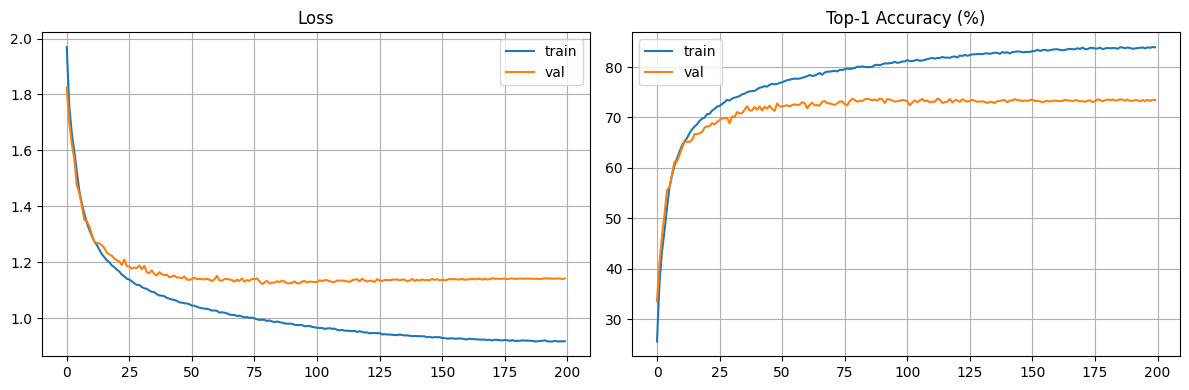

In [49]:
# Cell 10
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"],   label="val")
plt.title("Loss"); plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(history["train_acc1"], label="train")
plt.plot(history["val_acc1"],   label="val")
plt.title("Top-1 Accuracy (%)"); plt.legend(); plt.grid()

plt.tight_layout(); plt.show()

Loaded epoch 85 – Val Acc@1: 73.74%

=== TEST RESULTS ===
Loss: 1.1359
Acc@1: 72.34%
Acc@5: 97.84%

Classification Report
              precision    recall  f1-score   support

     class_0     0.7571    0.7200    0.7381      1000
     class_1     0.8582    0.8470    0.8525      1000
     class_2     0.6861    0.5420    0.6056      1000
     class_3     0.5433    0.5400    0.5416      1000
     class_4     0.6367    0.7150    0.6736      1000
     class_5     0.6643    0.5600    0.6077      1000
     class_6     0.7514    0.7950    0.7726      1000
     class_7     0.7096    0.7870    0.7463      1000
     class_8     0.7989    0.8740    0.8348      1000
     class_9     0.8126    0.8540    0.8328      1000

    accuracy                         0.7234     10000
   macro avg     0.7218    0.7234    0.7206     10000
weighted avg     0.7218    0.7234    0.7206     10000



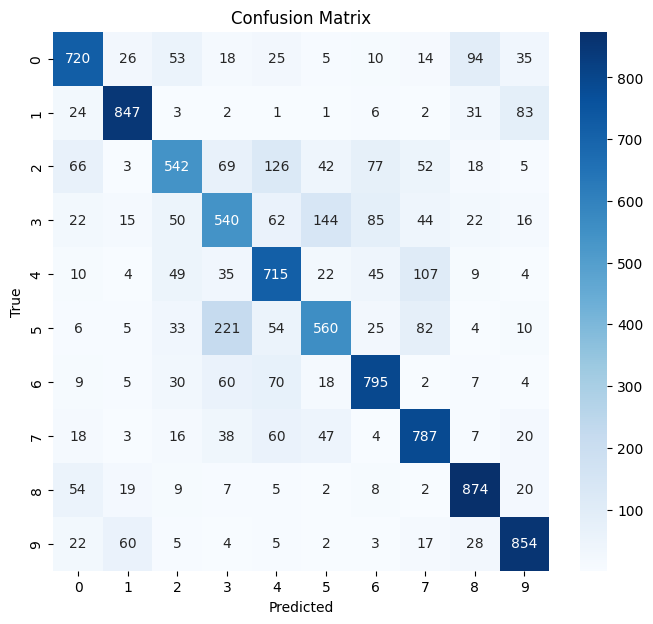

In [50]:
# Cell 11
ckpt = torch.load(f"microsign_cifar10_best_{VARIANT}.pth", map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
print(f"Loaded epoch {ckpt['epoch']} – Val Acc@1: {ckpt['val_acc']:.2f}%")

model.eval()
test_loss_meter = AverageMeter()
test_acc1_meter = AverageMeter()
test_acc5_meter = AverageMeter()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, targets in test_loader:
        imgs    = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with autocast(enabled=use_amp):
            logits = model(imgs)
            loss   = criterion(logits, targets)

        batch_size = imgs.size(0)
        acc1, acc5 = accuracy(logits, targets, topk=(1,5))

        test_loss_meter.update(loss.item(), batch_size)
        test_acc1_meter.update(acc1.item(), batch_size)
        test_acc5_meter.update(acc5.item(), batch_size)

        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

print("\n=== TEST RESULTS ===")
print(f"Loss: {test_loss_meter.avg:.4f}")
print(f"Acc@1: {test_acc1_meter.avg:.2f}%")
print(f"Acc@5: {test_acc5_meter.avg:.2f}%")

# Classification report
print("\nClassification Report")
print(classification_report(all_labels, all_preds,
                            target_names=[f"class_{i}" for i in range(10)], digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

In [33]:
!pip install timm

In [ ]:
# Cell 13 – Train ONLY the official PyTorch / TIMM models (no MicroSign-Net)
# ------------------------------------------------------------------
# This cell:
#   • Defines a list of standard models
#   • Trains each for 30 epochs (fast fair comparison)
#   • Caches best checkpoint per model
#   • Stores final test accuracy in `benchmark_results`
# ------------------------------------------------------------------

import timm
from torchvision import models
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast

# -------------------------- Check Available TIMM Models --------------------------
def get_safe_timm_model(model_name, fallback_name, num_classes=10):
    """Try to create a TIMM model, fallback if not available"""
    try:
        return timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    except RuntimeError:
        print(f"  ⚠️  Model '{model_name}' not found, trying '{fallback_name}'...")
        try:
            return timm.create_model(fallback_name, pretrained=False, num_classes=num_classes)
        except RuntimeError:
            print(f"  ❌ Fallback '{fallback_name}' also failed. Skipping this model.")
            return None

# -------------------------- Model Zoo --------------------------
model_factory = {
    # # Classic CNNs
    # "ResNet-18":          lambda: models.resnet18(num_classes=10),
    # "ResNet-34":          lambda: models.resnet34(num_classes=10),
    # "ResNet-50":          lambda: models.resnet50(num_classes=10),
    # "ResNet-101":         lambda: models.resnet101(num_classes=10),
    # "Wide-ResNet-50":     lambda: models.wide_resnet50_2(num_classes=10),
    
    # # DenseNet Family
    # "DenseNet-121":       lambda: models.densenet121(num_classes=10),
    # "DenseNet-169":       lambda: models.densenet169(num_classes=10),
    
    # # VGG Family
    # "VGG-11":             lambda: models.vgg11_bn(num_classes=10),
    # "VGG-16":             lambda: models.vgg16_bn(num_classes=10),
    
    # # Inception
    # "Inception-V3":       lambda: models.inception_v3(num_classes=10, aux_logits=False),
    
    # Mobile/Efficient Models
    "MobileNet-V2":       lambda: models.mobilenet_v2(num_classes=10),
    "MobileNet-V3-Small": lambda: models.mobilenet_v3_small(num_classes=10),
    "MobileNet-V3-Large": lambda: models.mobilenet_v3_large(num_classes=10),
    "ShuffleNet-V2-x0.5": lambda: models.shufflenet_v2_x0_5(num_classes=10),
    "ShuffleNet-V2-x1.0": lambda: models.shufflenet_v2_x1_0(num_classes=10),
    "SqueezeNet-1.0":     lambda: models.squeezenet1_0(num_classes=10),
    "SqueezeNet-1.1":     lambda: models.squeezenet1_1(num_classes=10),
    
    # # EfficientNet Family (TIMM)
    # "EfficientNet-B0":    lambda: get_safe_timm_model('efficientnet_b0', 'tf_efficientnet_b0'),
    # "EfficientNet-B1":    lambda: get_safe_timm_model('efficientnet_b1', 'tf_efficientnet_b1'),
    # "EfficientNet-B2":    lambda: get_safe_timm_model('efficientnet_b2', 'tf_efficientnet_b2'),
    # "EfficientNet-Lite0": lambda: get_safe_timm_model('efficientnet_lite0', 'tf_efficientnet_lite0'),
    
    # # RegNet Family (TIMM)
    # "RegNet-Y-400MF":     lambda: get_safe_timm_model('regnety_040', 'regnety_004'),
    # "RegNet-Y-800MF":     lambda: get_safe_timm_model('regnety_080', 'regnety_008'),
    # "RegNet-X-400MF":     lambda: get_safe_timm_model('regnetx_040', 'regnetx_004'),
    
    # # Vision Transformer variants (TIMM)
    # "ViT-Tiny":           lambda: get_safe_timm_model('vit_tiny_patch16_224', 'vit_small_patch16_224'),
    # "DeiT-Tiny":          lambda: get_safe_timm_model('deit_tiny_patch16_224', 'deit_small_patch16_224'),
    
    # # ConvNeXt (TIMM)
    # "ConvNeXt-Tiny":      lambda: get_safe_timm_model('convnext_tiny', 'convnext_small'),
    # "ConvNeXt-Atto":      lambda: get_safe_timm_model('convnext_atto', 'convnext_tiny'),
    
    # # MobileViT (TIMM)
    # "MobileViT-XS":       lambda: get_safe_timm_model('mobilevit_xs', 'mobilevit_s'),
    # "MobileViT-S":        lambda: get_safe_timm_model('mobilevit_s', 'mobilevit_xs'),
    
    # # MaxViT (TIMM)
    # "MaxViT-Tiny":        lambda: get_safe_timm_model('maxvit_tiny_tf_224', 'maxvit_small_tf_224'),
    
    # # EfficientNetV2 (TIMM)
    # "EfficientNetV2-S":   lambda: get_safe_timm_model('efficientnetv2_s', 'tf_efficientnetv2_s'),
    
    # # ResNeXt (TIMM)
    # "ResNeXt-50":         lambda: get_safe_timm_model('resnext50_32x4d', 'resnext50d_32x4d'),
    
    # # MNASNet (torchvision)
    # "MNASNet-1.0":        lambda: models.mnasnet1_0(num_classes=10),
    
    # # GoogLeNet
    # "GoogLeNet":          lambda: models.googlenet(num_classes=10, aux_logits=False),
}

# -------------------------- Training Config --------------------------
EPOCHS = 30
CACHE_DIR = Path("./bench_cache")
CACHE_DIR.mkdir(exist_ok=True)
benchmark_results = {}

# -------------------------- Helper Functions --------------------------
def save_ckpt(model, name, acc):
    path = CACHE_DIR / f"{name}.pth"
    torch.save({"state_dict": model.state_dict(), "val_acc": acc}, path)

def load_ckpt(model, name):
    path = CACHE_DIR / f"{name}.pth"
    if path.exists():
        ckpt = torch.load(path, map_location=device)
        model.load_state_dict(ckpt["state_dict"])
        return ckpt["val_acc"]
    return None

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def count_parameters(model):
    """Count total and trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def get_model_size(model):
    """Get model size in MB"""
    param_size = 0
    buffer_size = 0
    
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_mb = (param_size + buffer_size) / 1024**2
    return size_mb

# -------------------------- Main Loop --------------------------
for name, factory in model_factory.items():
    print(f"\n{'='*20} Training {name} {'='*20}")
    
    # Create model
    model = factory()
    
    # Skip if model creation failed
    if model is None:
        print(f"  ⏭️  Skipping {name}")
        continue
    
    model = model.to(device)
    model_name = name.replace(" ", "_").replace("-", "_")
    
    # Get model statistics
    total_params, trainable_params = count_parameters(model)
    model_size_mb = get_model_size(model)
    
    print(f"  📊 Parameters: {total_params:,} ({total_params/1e6:.2f}M) | Size: {model_size_mb:.2f} MB")

    # Load cache if exists
    cached_acc = load_ckpt(model, model_name)
    if cached_acc is not None:
        print(f"  → Loaded cached weights (Val Acc@1: {cached_acc:.2f}%)")
    else:
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        best_acc = 0.0

        for epoch in range(EPOCHS):
            # --- Train ---
            model.train()
            train_loss = 0.0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad(set_to_none=True)
                with autocast(enabled=use_amp):
                    loss = criterion(model(x), y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                train_loss += loss.item()
            
            scheduler.step()

            # --- Val ---
            model.eval()
            correct = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    correct += (model(x).argmax(1) == y).sum().item()
            acc = correct / len(val_set) * 100
            if acc > best_acc:
                best_acc = acc
                save_ckpt(model, model_name, best_acc)

            print(f"  Epoch {epoch+1:02d} | Val Acc@1: {acc:.2f}% | Best: {best_acc:.2f}%")

        # Reload best checkpoint
        load_ckpt(model, model_name)

    # --- Final Test ---
    model.eval()
    correct1 = correct5 = total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            acc1, acc5 = accuracy(logits, y, topk=(1,5))
            correct1 += acc1.item() * y.size(0) / 100
            correct5 += acc5.item() * y.size(0) / 100
            total += y.size(0)
    test_acc1 = correct1 / total * 100
    test_acc5 = correct5 / total * 100

    benchmark_results[name] = {
        "Top-1": test_acc1, 
        "Top-5": test_acc5,
        "Params": total_params,
        "Params(M)": total_params / 1e6,
        "Size(MB)": model_size_mb
    }
    print(f"  ✓ Test → Top-1: {test_acc1:.2f}% | Top-5: {test_acc5:.2f}%")

print("\n" + "="*80)
print("FINAL BENCHMARK RESULTS")
print("="*80)
print(f"{'Model':<25} {'Params(M)':<12} {'Size(MB)':<10} {'Top-1':<8} {'Top-5':<8}")
print("-"*80)

# Sort by Top-1 accuracy (descending)
sorted_results = sorted(benchmark_results.items(), key=lambda x: x[1]['Top-1'], reverse=True)

for n, r in sorted_results:
    print(f"{n:<25} {r['Params(M)']:>10.2f}  {r['Size(MB)']:>9.2f}  {r['Top-1']:>7.2f}% {r['Top-5']:>7.2f}%")

print("="*80)

# Additional statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

# Best accuracy
best_model = max(benchmark_results.items(), key=lambda x: x[1]['Top-1'])
print(f"🏆 Best Accuracy: {best_model[0]} ({best_model[1]['Top-1']:.2f}%)")

# Most efficient (best accuracy per parameter)
efficiency = {name: r['Top-1'] / r['Params(M)'] for name, r in benchmark_results.items()}
most_efficient = max(efficiency.items(), key=lambda x: x[1])
print(f"⚡ Most Efficient: {most_efficient[0]} ({efficiency[most_efficient[0]]:.2f} acc/M params)")

# Smallest model
smallest = min(benchmark_results.items(), key=lambda x: x[1]['Params(M)'])
print(f"📦 Smallest Model: {smallest[0]} ({smallest[1]['Params(M)']:.2f}M params, {smallest[1]['Top-1']:.2f}% acc)")

# Largest model
largest = max(benchmark_results.items(), key=lambda x: x[1]['Params(M)'])
print(f"🦖 Largest Model: {largest[0]} ({largest[1]['Params(M)']:.2f}M params, {largest[1]['Top-1']:.2f}% acc)")

print("="*80)


==================== Training ResNet-18 ====================
  📊 Parameters: 11,181,642 (11.18M) | Size: 42.69 MB
  → Loaded cached weights (Val Acc@1: 78.90%)
  ✓ Test → Top-1: 77.68% | Top-5: 94.14%

==================== Training ResNet-34 ====================
  📊 Parameters: 21,289,802 (21.29M) | Size: 81.28 MB
  → Loaded cached weights (Val Acc@1: 77.64%)
  ✓ Test → Top-1: 76.93% | Top-5: 94.10%

==================== Training ResNet-50 ====================
  📊 Parameters: 23,528,522 (23.53M) | Size: 89.96 MB
  → Loaded cached weights (Val Acc@1: 74.62%)
  ✓ Test → Top-1: 74.68% | Top-5: 92.94%

==================== Training ResNet-101 ====================
  📊 Parameters: 42,520,650 (42.52M) | Size: 162.61 MB
  Epoch 01 | Val Acc@1: 43.48% | Best: 43.48%
  Epoch 02 | Val Acc@1: 39.34% | Best: 43.48%
  Epoch 03 | Val Acc@1: 37.56% | Best: 43.48%
  Epoch 04 | Val Acc@1: 53.96% | Best: 53.96%
  Epoch 05 | Val Acc@1: 46.54% | Best: 53.96%
  Epoch 06 | Val Acc@1: 37.82% | Best: 53.96%
 

/home/m11207824/miniconda3/envs/playground/lib/python3.8/site-packages/torchvision/models/inception.py:44: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size